In [1]:
import yaml
import numpy as np
import shapely.affinity as aff
import shapely.geometry as geo
import shapely.ops as ops

In [2]:
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

import descartes as des

In [3]:
import sys
sys.path.append("../")

from electronfactors.ellipse.utilities import shapely_cutout, shapely_point

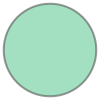

In [4]:
with open("output/AllInputs_guessed.yml", 'r') as inputFile:
    AllInputs_guessed = yaml.load(inputFile)

XCoords = AllInputs_guessed['Simon 6cm circle']['XCoords']
YCoords = AllInputs_guessed['Simon 6cm circle']['YCoords']

# XCoords = AllInputs_guessed['Simon #16 cutout']['XCoords']
# YCoords = AllInputs_guessed['Simon #16 cutout']['YCoords']

# XCoords = AllInputs_guessed['Simon #73 cutout']['XCoords']
# YCoords = AllInputs_guessed['Simon #73 cutout']['YCoords']



cutout = shapely_cutout(XCoords, YCoords)
cutout

In [5]:
centre = [0,0]
centredCutout = aff.translate(cutout, xoff=-centre[0], yoff=-centre[1])

In [6]:
shapely_point(0,0).distance(centredCutout.boundary)

2.996386368615516

In [7]:
# def create_zones(numZones, maxRadii):
#     zoneBoundaryRadii = np.linspace(0, maxRadii, numZones + 1)
#     zoneBoundaries = [0]*(numZones+1)
#     zoneRegions = [0]*numZones
#     zoneMidDist = (zoneBoundaryRadii[0:-1] + zoneBoundaryRadii[1:])/2

#     for i in range(numZones + 1):
#         zoneBoundaries[i] = geo.Point(0, 0).buffer(zoneBoundaryRadii[i])

#     for i in range(numZones):
#         zoneRegions[i] = zoneBoundaries[i+1].difference(zoneBoundaries[i])

#     return zoneMidDist, zoneRegions

In [8]:
# Have each zone overlap halfway

maxRadii = np.max(centredCutout.bounds) * np.sqrt(2)
numZones = 300

zoneWidth = maxRadii / numZones * 1.5
zoneMinBound = np.linspace(0, maxRadii - zoneWidth, numZones)
zoneMaxBound = zoneMinBound + zoneWidth

def shapely_circle(radii):
    return geo.Point(0, 0).buffer(radii)

zone_list = [
    shapely_circle(zoneMaxBound[i]).difference(shapely_circle(zoneMinBound[i])) 
    for i in range(numZones)
]

In [9]:
zones = [geo.Polygon(zone_list[i]) for i in range(numZones)]
zoneMidDist = (zoneMaxBound + zoneMinBound) / 2

zoneRegions = zones

In [10]:
# maxRadii = np.max(centredCutout.bounds) * np.sqrt(2)
# numZones = 100

# zoneMidDist, zoneRegions = create_zones(numZones, maxRadii) # Make the zones with multipolygons

In [11]:
zoneRatioAreas = np.zeros(numZones)

for i in range(numZones):
    intersectionArea = centredCutout.intersection(zoneRegions[i]).area
    zoneArea = zoneRegions[i].area
    zoneRatioAreas[i] = intersectionArea / zoneArea

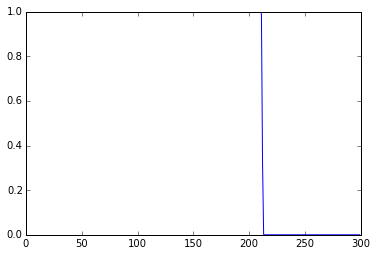

In [12]:
plt.plot(zoneRatioAreas)

In [13]:
def create_intersection_cut(ratio):
    placementAngle = np.pi/2 * (1 - ratio)
    x = np.sqrt(2) * maxRadii * np.cos(placementAngle)
    y = np.sqrt(2) * maxRadii * np.sin(placementAngle)
    
    top_cut_coords = [(-x, y), (x, y), (0,0)]
    bottom_cut_coords = [(-x, -y), (x, -y), (0,0)]

    top_cut = geo.Polygon(top_cut_coords)
    bottom_cut = geo.Polygon(bottom_cut_coords)

    intersection_cut = geo.MultiPolygon([top_cut, bottom_cut])
    
    return intersection_cut


def create_difference_cut(ratio):
    placementAngle = np.pi/2 * (1 - ratio)
    x = np.sqrt(2) * maxRadii * np.cos(placementAngle)
    y = np.sqrt(2) * maxRadii * np.sin(placementAngle)
    
    left_cut_coords = [(-x, -y), (-x, y), (0,0)]
    right_cut_coords = [(x, y), (x, -y), (0,0)]

    left_cut = geo.Polygon(left_cut_coords)
    right_cut = geo.Polygon(right_cut_coords)

    difference_cut = geo.MultiPolygon([left_cut, right_cut])
    
    return difference_cut


def create_segment(region, ratio):
    if (ratio >= 0.5) & (ratio < 1):
        cut = create_difference_cut(ratio)
        segment = region.difference(cut)
        return segment
        
    elif (ratio > 0):
        cut = create_intersection_cut(ratio)
        segment = region.intersection(cut)
        return segment
        
    else:
        raise Exception("Unexpected ratio")

In [14]:
ploygon_list = []

for i in range(numZones):
    if zoneRatioAreas[i] == 1:
        ploygon_list.append(zoneRegions[i])
        
    elif zoneRatioAreas[i] > 0:
        add_section = create_segment(zoneRegions[i], zoneRatioAreas[i])
        ploygon_list.append(add_section)

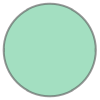

In [15]:
straightened = ops.unary_union(ploygon_list)
straightened

(-3.0, 3.0, -4.0, 4.0)

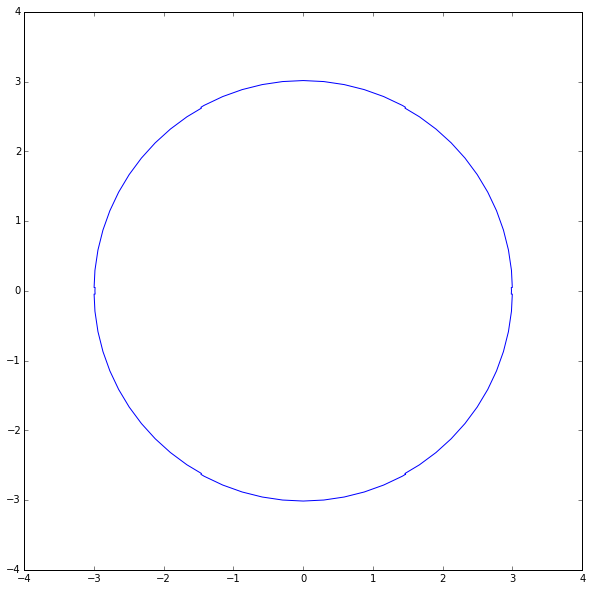

In [16]:
x, y = straightened.boundary.xy
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x, y)
plt.axis("equal")

In [17]:
ratio = 0.5

placementAngle = np.pi/2 * (1 - ratio)

x = np.sqrt(2) * maxRadii * np.cos(placementAngle)
y = np.sqrt(2) * maxRadii * np.sin(placementAngle)

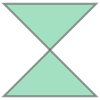

In [18]:
top_cut_coords = [(-x, y), (x, y), (0,0)]
bottom_cut_coords = [(-x, -y), (x, -y), (0,0)]

top_cut = geo.Polygon(top_cut_coords)
bottom_cut = geo.Polygon(bottom_cut_coords)

cut_shape = geo.MultiPolygon([top_cut, bottom_cut])
cut_shape

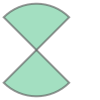

In [19]:
zoneRegions[0].intersection(cut_shape)

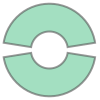

In [20]:
create_segment(zoneRegions[1], 0.9)